# Analysis review

## Overview

This notebook follows the tutorial by [mousepixels/sanbomics](https://github.com/mousepixels/sanbomics/blob/main/single_cell_analysis_complete_class.ipynb), which has an accompanying [screencast](https://youtu.be/uvyG9yLuNSE?t=319).

Analysis is illustrated with single-nucleus RNA sequencing data from the following paper <cite data-cite="Melms2021-bj">Melms et al. (2021)</cite>

> Melms JC, Biermann J, Huang H, Wang Y, Nair A, Tagore S, et al.
A molecular single-cell lung atlas of lethal COVID-19.
Nature. 2021;595: 114–119. [doi:10.1038/s41586-021-03569-0](https://doi.org/10.1038/s41586-021-03569-0)

This paper examined 116,000 nuclei from the lungs of nineteen patients who underwent autopsy following death in association with COVID-19. Findings reported in the abstract of the paper include:

1. activated monocyte-derived macrophages and alveolar macrophages
1. impaired T cell activation
1. monocyte/macrophage-derived interleukin-1β and epithelial cell-derived interleukin-6
1. alveolar type 2 cells adopted an inflammation-associated transient progenitor cell state and failed to undergo full transition into alveolar type 1 cells
1. expansion of CTHRC1+ pathological fibroblasts
1. protein activity and ligand–receptor interactions suggest putative drug targets

This notebook makes extensive use of <cite data-cite="Wolf2018-nu">Wolf et al. (2018)</cite> and <cite data-cite="Lopez2018-em">Lopez et al. (2018)</cite> including updates that have been made to the underlying software packages, [scanpy](https://github.com/scverse/scanpy) and [scvi-tools](https://github.com/scverse/scvi-tools), since their initial publication.

## Setup

### Import libraries

In [1]:
from inspect import getmembers
from pprint import pprint
from types import FunctionType

import pickle
import scanpy as sc
import scvi
import seaborn as sns

Global seed set to 0
/usr/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


### Setup plotting

In [2]:
import matplotlib.font_manager
import matplotlib.pyplot as plt

# import matplotlib_inline

In [3]:
# fonts_path = "/usr/share/texmf/fonts/opentype/public/lm/" #ubuntu
# fonts_path = "~/Library/Fonts/" # macos
fonts_path = "/usr/share/fonts/OTF/"  # arch
# user_path = "$HOME/" # user
# fonts_path = user_path + "fonts/latinmodern/opentype/public/lm/"  # home
matplotlib.font_manager.fontManager.addfont(fonts_path + "lmsans10-regular.otf")
matplotlib.font_manager.fontManager.addfont(fonts_path + "lmroman10-regular.otf")

In [4]:
# https://stackoverflow.com/a/36622238/446907
%config InlineBackend.figure_formats = ['svg']

In [5]:
plt.style.use("default")  # reset default parameters
# https://stackoverflow.com/a/3900167/446907
plt.rcParams.update(
    {
        "font.size": 16,
        "font.family": ["sans-serif"],
        "font.serif": ["Latin Modern Roman"] + plt.rcParams["font.serif"],
        "font.sans-serif": ["Latin Modern Sans"] + plt.rcParams["font.sans-serif"],
    }
)

### Utility functions

In [6]:
def attributes(obj):
    """
    get object attributes
    """
    disallowed_names = {
        name for name, value in getmembers(type(obj)) if isinstance(value, FunctionType)
    }
    return {
        name: getattr(obj, name)
        for name in dir(obj)
        if name[0] != "_" and name not in disallowed_names and hasattr(obj, name)
    }


def print_attributes(obj):
    """
    print object attributes
    """
    pprint(attributes(obj))

## Import data

Here we review how the data were downloaded, and proceed to import and inspect the data.

### Data download

Data with GEO accession [GSE171524](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171524) was downloaded using [./data/download_geo_data.sh](./data/download_geo_data.sh) with parameters

```bash
./download_geo_data.sh \
       -a GSE132771 \
       -f 'ftp.*RAW.*' \
       -j '..|.supplementary_files?|..|.url?|select(length>0)'
```

A skeleton of this script that may work in this case is

```bash
!/usr/bin/env bash

#-- debugging (comment to reduce stderr output)
#-- https://wiki.bash-hackers.org/scripting/debuggingtips
export PS4='+(${BASH_SOURCE}:${LINENO}): ${FUNCNAME[0]:+${FUNCNAME[0]}(): }'
set -o xtrace

# get metadata
# Melms JC, Biermann J, Huang H, Wang Y, Nair A, Tagore S, et al.
# A molecular single-cell lung atlas of lethal COVID-19.
# Nature. 2021;595: 114–119. doi:10.1038/s41586-021-03569-0
# GSE171524
ffq -l 1 -o GSE171524.json GSE171524

# download raw data
wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE171nnn/GSE171524/suppl/GSE171524_RAW.tar

# list contents
tar -tvf GSE171524_RAW.tar

# untar
mkdir -p GSE171524 && \
tar -xvf GSE171524_RAW.tar -C GSE171524
```

### Data load

See the [documentation for scanpy read csv](https://scanpy.readthedocs.io/en/latest/generated/scanpy.read_csv.html) which returns an [AnnData object](https://anndata.readthedocs.io/en/stable/generated/anndata.AnnData.html#anndata.AnnData).

In [7]:
adata = None
adata = sc.read_csv(
    "data/GSE171524/supplementary/GSM5226574_C51ctr_raw_counts.csv.gz"
).T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

Note the `scanpy.read_csv` function accepts gzipped files.

### Data properties

In [8]:
type(adata)

anndata._core.anndata.AnnData

In [9]:
adata.X.shape

(6099, 34546)

In [10]:
print_attributes(adata)

{'T': AnnData object with n_obs × n_vars = 34546 × 6099,
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'file': Backing file manager: no file is set.,
 'filename': None,
 'is_view': False,
 'isbacked': False,
 'isview': False,
 'layers': Layers with keys: ,
 'n_obs': 6099,
 'n_vars': 34546,
 'obs': Empty DataFrame
Columns: []
Index: [TAGGTACCATGGCCAC-1_1, ATTCACTGTAACAGGC-1_1, TAACTTCCAACCACGC-1_1, TTGGGTACACGACAAG-1_1, AGGCCACAGAGTCACG-1_1, CACTGAAGTCGAAGCA-1_1, ACTGATGTCTGCACCT-1_1, TTACCGCCACTCAGAT-1_1, TTGGTTTTCCTAGCTC-1_1, TGGGAAGTCAGTGATC-1_1, CCACGAGTCTCTTAAC-1_1, ACTTCCGCACAACGCC-1_1, GGGAAGTAGCGACCCT-1_1, TGGTAGTTCCCGTGTT-1_1, CGCATAACATGCCGGT-1_1, TCTATCACAAGGCTTT-1_1, ATCCACCAGAGGTATT-1_1, TAACGACAGATGACCG-1_1, TCTTAGTGTATGAGGC-1_1, CACTTCGCAGTACTAC-1_1, GTCAAAC

/tmp/ipykernel_223/22660072.py:11: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if name[0] != "_" and name not in disallowed_names and hasattr(obj, name)
/tmp/ipykernel_223/22660072.py:9: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  name: getattr(obj, name)


In [11]:
adata.obs

""
TAGGTACCATGGCCAC-1_1
ATTCACTGTAACAGGC-1_1
TAACTTCCAACCACGC-1_1
TTGGGTACACGACAAG-1_1
AGGCCACAGAGTCACG-1_1
...
CGCCATTGTTTGCCGG-1_1
CACTGGGGTCTACGTA-1_1
CATACTTGTAGAGGAA-1_1
TTTGGTTTCCACGGAC-1_1


Gene names are saved as `adata.var`.

In [12]:
adata.var

""
AL627309.1
AL627309.5
AL627309.4
AL669831.2
LINC01409
...
VN1R2
AL031676.1
SMIM34A
AL050402.1


In [13]:
adata.obs_names

Index(['TAGGTACCATGGCCAC-1_1', 'ATTCACTGTAACAGGC-1_1', 'TAACTTCCAACCACGC-1_1',
       'TTGGGTACACGACAAG-1_1', 'AGGCCACAGAGTCACG-1_1', 'CACTGAAGTCGAAGCA-1_1',
       'ACTGATGTCTGCACCT-1_1', 'TTACCGCCACTCAGAT-1_1', 'TTGGTTTTCCTAGCTC-1_1',
       'TGGGAAGTCAGTGATC-1_1',
       ...
       'AAGTCGTGTGTGAATA-1_1', 'GTCGTTCTCCAAGGGA-1_1', 'GTTTGGATCGGCCTTT-1_1',
       'GTACAGTCACGTATAC-1_1', 'TCATGCCCAAGAGGTC-1_1', 'CGCCATTGTTTGCCGG-1_1',
       'CACTGGGGTCTACGTA-1_1', 'CATACTTGTAGAGGAA-1_1', 'TTTGGTTTCCACGGAC-1_1',
       'ATGCATGAGTCATGAA-1_1'],
      dtype='object', length=6099)

In [14]:
adata.var_names

Index(['AL627309.1', 'AL627309.5', 'AL627309.4', 'AL669831.2', 'LINC01409',
       'FAM87B', 'LINC01128', 'LINC00115', 'FAM41C', 'AL645608.6',
       ...
       'AC087190.2', 'AC136428.1', 'AC019183.1', 'AC105094.1', 'AC010485.1',
       'VN1R2', 'AL031676.1', 'SMIM34A', 'AL050402.1', 'AL445072.1'],
      dtype='object', length=34546)

There are no layers in this data set.

In [15]:
adata.layers

Layers with keys: 

There are no multidimensional observations or variables.

In [16]:
print(adata.obsm)
print(adata.varm)
print(adata.obsp)
print(adata.varp)

AxisArrays with keys: 
AxisArrays with keys: 
PairwiseArrays with keys: 
PairwiseArrays with keys: 


The data appears to contain reads mapped to 6099 cell-associated barcodes and 34546 RNA molecule-associated features.

## Doublet removal

### Filter transcripts by minimum number of cells with non-zero counts

We may choose to filter out transcript types that are detected in a relatively small number of cells. The optimum threshold is not known. Here we use 10 as a base case.

In [18]:
adata

AnnData object with n_obs × n_vars = 6099 × 34546

See the [documentation for scanpy pre-processing filter-genes](https://scanpy.readthedocs.io/en/latest/generated/scanpy.pp.filter_genes.html).

In [19]:
sc.pp.filter_genes(adata, min_cells=10)

In [20]:
adata

AnnData object with n_obs × n_vars = 6099 × 19896
    var: 'n_cells'

Following filtration there are 19896 transcript types remaining that are present in at least 10 cells. This means 14650 transcript types were removed at the threshold of 10. Notice that an annotation named `n_cells` has been added to the genes to indicate the number of cells with non-zero values for that transcript type.

In [21]:
adata.var

,n_cells
AL627309.5,33
LINC01409,274
LINC01128,81
LINC00115,15
SAMD11,16
...,...
MAFIP,34
AC011043.1,11
AL354822.1,133
AL592183.1,1003


In [45]:
adata.var.describe()

,n_cells,highly_variable_rank,means,variances,variances_norm
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,319.636000,999.500000,0.140495,1.135413,2.203288
std,377.720811,577.494568,0.282680,5.619025,1.171426
min,10.000000,0.000000,0.001968,0.002948,1.399341
25%,65.000000,499.750000,0.017216,0.040875,1.550249
50%,184.500000,999.500000,0.053123,0.148688,1.828523
75%,414.000000,1499.250000,0.148426,0.545860,2.346181
max,4546.000000,1999.000000,5.314150,135.394535,17.115198


<AxesSubplot:xlabel='n_cells', ylabel='Count'>

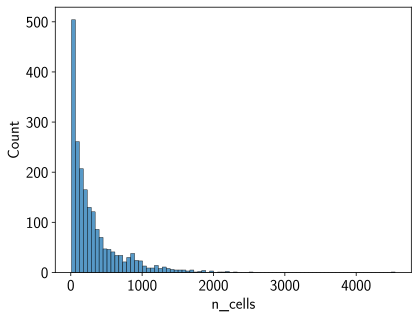

In [47]:
sns.histplot(adata.var['n_cells'])

### Select highly variable genes

It is common to select transcript types with high variability among the cell population under the assumption that this will help to focus on features that distinguish the cells. Again there is no perfect threshold. Here we select the 2000 highest variability genes.

In [22]:
adata

AnnData object with n_obs × n_vars = 6099 × 19896
    var: 'n_cells'

See the [documentation for scanpy pre-processing highly-variable-genes](https://scanpy.readthedocs.io/en/latest/generated/scanpy.pp.highly_variable_genes.html).

In [23]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor="seurat_v3")

In [24]:
adata

AnnData object with n_obs × n_vars = 6099 × 2000
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

We have filtered down to 2000 transcript types and added 5 annotations to the genes including a binary variable indicating membership in the highly-variable class, the ranking among highly variable genes, and the mean, variance, and normalized variance for each gene across cells.

In [25]:
adata.var

,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
TTLL10,112,True,903.0,0.028857,0.069354,1.901045
TNFRSF18,15,True,1604.0,0.002951,0.004911,1.513808
CFAP74,159,True,1370.0,0.041154,0.087024,1.607399
TTC34,209,True,245.0,0.080341,0.363502,3.044086
AJAP1,31,True,1922.0,0.006886,0.011432,1.421002
...,...,...,...,...,...,...
MT-ND4L,650,True,1212.0,0.191671,0.559353,1.695637
MT-ND4,1328,True,178.0,0.833087,9.742224,3.486984
MT-ND5,886,True,443.0,0.332514,1.669344,2.430210
MT-ND6,821,True,123.0,0.383178,3.357087,3.985056


### Doublet removal

Here we `scvi-tools` model as [an interface](https://docs.scvi-tools.org/en/stable/api/reference/scvi.external.SOLO.html) to [solo](https://github.com/calico/solo) from <cite data-cite="Bernstein2020-am">Bernstein et al. (2020)</cite>. `scvi` adds some unstructured data to interface with `torch`.

In [26]:
adata.uns

OverloadedDict, wrapping:
	OrderedDict([('hvg', {'flavor': 'seurat_v3'})])
With overloaded keys:
	['neighbors'].

In [27]:
scvi.model.SCVI.setup_anndata(adata)

In [28]:
adata.uns

OverloadedDict, wrapping:
	OrderedDict([('hvg', {'flavor': 'seurat_v3'}), ('_scvi_uuid', '290021be-0332-459c-9577-d34349c03ff4'), ('_scvi_manager_uuid', '49d2f232-173d-4da9-bff8-dd83ec7e62ad')])
With overloaded keys:
	['neighbors'].

Train the `scvi` model.

In [29]:
vae = scvi.model.SCVI(adata)
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100% 400/400 [03:27<00:00,  2.12it/s, loss=323, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100% 400/400 [03:27<00:00,  1.92it/s, loss=323, v_num=1]


After training the model `adata.obs` now contains `_scvi_batch` and `scvi_labels` annotations.

In [31]:
adata

AnnData object with n_obs × n_vars = 6099 × 2000
    obs: '_scvi_batch', '_scvi_labels'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'

In [32]:
adata.obs

,_scvi_batch,_scvi_labels
TAGGTACCATGGCCAC-1_1,0,0
ATTCACTGTAACAGGC-1_1,0,0
TAACTTCCAACCACGC-1_1,0,0
TTGGGTACACGACAAG-1_1,0,0
AGGCCACAGAGTCACG-1_1,0,0
...,...,...
CGCCATTGTTTGCCGG-1_1,0,0
CACTGGGGTCTACGTA-1_1,0,0
CATACTTGTAGAGGAA-1_1,0,0
TTTGGTTTCCACGGAC-1_1,0,0


Train the `solo` model.

In [34]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                            


/usr/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 207/400:  52% 207/400 [01:43<01:36,  2.01it/s, loss=0.299, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.295. Signaling Trainer to stop.


In [35]:
type(solo)

scvi.external.solo._model.SOLO

We can now use the `solo` model to add a prediction annotation for doublet or singlet to our data.

In [36]:
df = solo.predict()
df["prediction"] = solo.predict(soft=False)

df.index = df.index.map(lambda x: x[:-2])

df

,doublet,singlet,prediction
TAGGTACCATGGCCAC-1_1,1.729540,-0.992126,doublet
ATTCACTGTAACAGGC-1_1,2.275840,-1.639090,doublet
TAACTTCCAACCACGC-1_1,0.735813,-0.259502,doublet
TTGGGTACACGACAAG-1_1,1.618703,-0.680344,doublet
AGGCCACAGAGTCACG-1_1,1.398426,-0.673206,doublet
...,...,...,...
CGCCATTGTTTGCCGG-1_1,-0.691126,1.362337,singlet
CACTGGGGTCTACGTA-1_1,-2.632991,2.468916,singlet
CATACTTGTAGAGGAA-1_1,-2.506424,2.567346,singlet
TTTGGTTTCCACGGAC-1_1,-3.308819,2.476630,singlet


Counting the predicted doublets and singlets reveals about 20% doublets.

In [37]:
df.groupby("prediction").count()

,doublet,singlet
prediction,,
doublet,1206,1206
singlet,4893,4893


We can assess the magnitude of the prediction by taking the difference between the doublet and singlet scores.

In [38]:
df["dif"] = df.doublet - df.singlet
df

,doublet,singlet,prediction,dif
TAGGTACCATGGCCAC-1_1,1.729540,-0.992126,doublet,2.721666
ATTCACTGTAACAGGC-1_1,2.275840,-1.639090,doublet,3.914930
TAACTTCCAACCACGC-1_1,0.735813,-0.259502,doublet,0.995315
TTGGGTACACGACAAG-1_1,1.618703,-0.680344,doublet,2.299047
AGGCCACAGAGTCACG-1_1,1.398426,-0.673206,doublet,2.071632
...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,-0.691126,1.362337,singlet,-2.053463
CACTGGGGTCTACGTA-1_1,-2.632991,2.468916,singlet,-5.101907
CATACTTGTAGAGGAA-1_1,-2.506424,2.567346,singlet,-5.073770
TTTGGTTTCCACGGAC-1_1,-3.308819,2.476630,singlet,-5.785450


Plotting the distribution of doublet-singlet score differences we see there are a large fraction that marginally favor doublet to singlet.

<AxesSubplot:xlabel='dif', ylabel='Count'>

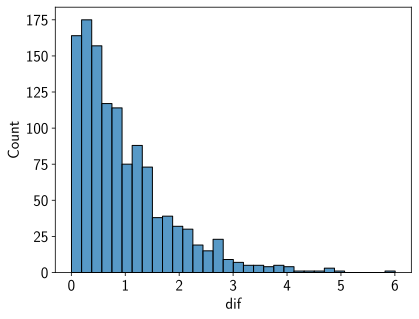

In [9]:
sns.histplot(df[df.prediction == "doublet"], x="dif")

Since we would like to avoid unnecessarily discarding barcodes, we will arbitrarily retain those with a score from zero to one (however this is not intended to be principled).

In [42]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
doublets

,doublet,singlet,prediction,dif
TAGGTACCATGGCCAC-1_1,1.729540,-0.992126,doublet,2.721666
ATTCACTGTAACAGGC-1_1,2.275840,-1.639090,doublet,3.914930
TTGGGTACACGACAAG-1_1,1.618703,-0.680344,doublet,2.299047
AGGCCACAGAGTCACG-1_1,1.398426,-0.673206,doublet,2.071632
CACTGAAGTCGAAGCA-1_1,1.305717,-0.544905,doublet,1.850623
...,...,...,...,...
CAATACGCAATGTGGG-1_1,0.471522,-0.923330,doublet,1.394853
GGGTATTTCAGCGCAC-1_1,1.101736,-0.658175,doublet,1.759911
TTGCTGCAGTGCGACA-1_1,0.720216,-0.624341,doublet,1.344557
CATCCCAAGACGCCAA-1_1,0.937599,-0.486121,doublet,1.423720


<AxesSubplot:xlabel='dif', ylabel='Count'>

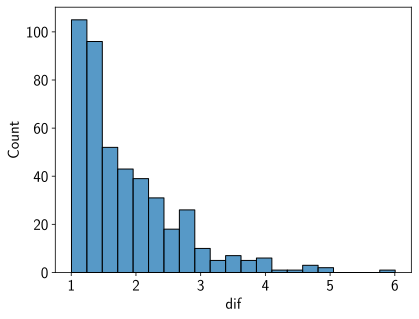

In [8]:
sns.histplot(doublets[doublets.prediction == "doublet"], x="dif")

### Save/load checkpoint 

Save current variables to file.

In [ ]:
pickle.dump([adata, df, doublets, solo, vae], open("session_09282022.p", "wb"))

Variables can be reloaded if necessary.

In [7]:
adata, df, doublets, solo, vae = pickle.load(open("session_09282022.p", "rb"))

### Reload data and filter doublets

In [10]:
adata = sc.read_csv(
    "data/GSE171524/supplementary/GSM5226574_C51ctr_raw_counts.csv.gz"
).T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

Annotate `adata` with doublet column.

In [58]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)

In [59]:
adata

AnnData object with n_obs × n_vars = 6099 × 34546
    obs: 'doublet'

In [60]:
adata.obs

,doublet
TAGGTACCATGGCCAC-1_1,True
ATTCACTGTAACAGGC-1_1,True
TAACTTCCAACCACGC-1_1,False
TTGGGTACACGACAAG-1_1,True
AGGCCACAGAGTCACG-1_1,True
...,...
CGCCATTGTTTGCCGG-1_1,False
CACTGGGGTCTACGTA-1_1,False
CATACTTGTAGAGGAA-1_1,False
TTTGGTTTCCACGGAC-1_1,False


Use doublet column to filter doublets.

In [61]:
adata = adata[~adata.obs.doublet]

In [62]:
adata

View of AnnData object with n_obs × n_vars = 5648 × 34546
    obs: 'doublet'

We filtered about 7% of the barcodes as putative doublets.

## Preprocessing

### Filter mitochondrial transcripts